# Descripción
Primera versión del modelo de estimación de fechas de aprobacion sin mucha limpieza de datos

In [1]:
import numpy as np
import pandas as pd
import missingno as msn
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [2]:
#Direccion del documento
#path=os.path.dirname(os.path.realpath('Ordenes%20de%20compra%20PORTAL%201K%20(datos%20completo).xlsx'))
#path

In [3]:
#Subir la dirección local de donde tengan los datos
df=pd.read_excel('C:\\Users\\Admin\\OneDrive\\Documentos\\DataScience2021-2\\Trabajos_propios_felipe\\Proyecto_final\\Ordenes de compra PORTAL 1K (datos completo).xlsx')

In [4]:
#Manejo inicial de base de datos
df.drop(labels=['Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28'],axis=1,inplace=True)
df.drop_duplicates(inplace=True)

#Cambiando formato de variables
df['FECHA ORDEN']=pd.to_datetime(df['FECHA ORDEN'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA ENTREGA']=pd.to_datetime(df['FECHA ENTREGA'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA APROBACION']=pd.to_datetime(df['FECHA APROBACION'],format='%Y-%m-%d',errors = 'coerce')
df['FECHA ULTIMO MOVIMIENTO']=pd.to_datetime(df['FECHA ULTIMO MOVIMIENTO'],format='%Y-%m-%d',errors = 'coerce')
df['PRECIO UNITARIO']=df['PRECIO UNITARIO'].apply(lambda x:float(x.replace('.','')))
df['PRECIO UNITARIO + IVA']=df['PRECIO UNITARIO + IVA'].apply(lambda x:float(x.replace('.','')))
df['IVA']=df['IVA'].apply(lambda x:float(x.replace('.','')))
df['TOTAL SIN IVA']=df['TOTAL SIN IVA'].apply(lambda x:float(x.replace('.','')))
df['TOTAL + IVA']=df['TOTAL + IVA'].apply(lambda x:float(x.replace('.','')))

#Eliminamos columnas que no usaremos
df.drop(labels=['CANTIDAD RECIBIDA','CENTRO DE COSTOS','PRESUPUESTO'],inplace=True,axis=1)



In [5]:
#Creacion de nuevos features

#Con las fechas de aprobacion
df['dia fecha aprobacion']=df['FECHA APROBACION'].dt.dayofweek #0 lunes, 6 domingo
df['mes fecha aprobacion']=df['FECHA APROBACION'].dt.month #Meses de aprobación 
df['semana del año aprobacion']=df['FECHA APROBACION'].dt.isocalendar().week

#Con las fechas de orden
df['dia fecha orden']=df['FECHA ORDEN'].dt.dayofweek #0 lunes, 6 domingo
df['mes fecha orden']=df['FECHA ORDEN'].dt.month #Meses de ordbación 
df['semana del año orden']=df['FECHA ORDEN'].dt.isocalendar().week

#Variable objetivo
df['dias para aprobación']=df['FECHA APROBACION']-df['FECHA ORDEN']
df['dias para aprobación']=(df['FECHA APROBACION']-df['FECHA ORDEN']).dt.days

### TRATANDO OUTLAYERS

In [6]:
df.groupby('CATEGORÍA')['dias para aprobación'].mean().sort_values(ascending=False).head(10)

CATEGORÍA
Vigilancia y seguridad industrial              43.528299
Vigilancia y seguridad                         39.241379
Moda y accesorios                              22.695652
Vehículos y repuestos                           6.428571
Medicina y Salud                                5.600000
Dotación y elementos de protección personal     3.312707
Gestión ambiental                               2.829268
Cuidado personal y Belleza                      2.250000
Textiles                                        2.021429
Compras Sostenibles                             1.619048
Name: dias para aprobación, dtype: float64

In [170]:
df['dias para aprobación'].describe()

count    21259.000000
mean        13.368550
std         28.016148
min          0.000000
25%          0.000000
50%          0.000000
75%          7.000000
max        573.000000
Name: dias para aprobación, dtype: float64

In [171]:
df.groupby('CATEGORÍA')['dias para aprobación'].agg(['max','mean','median']).sort_values(by='mean',ascending=False).head(10)

,max,mean,median
CATEGORÍA,,,
Vigilancia y seguridad industrial,118.0,43.528299,48.0
Vigilancia y seguridad,573.0,39.241379,1.0
Moda y accesorios,532.0,22.695652,0.0
Vehículos y repuestos,549.0,6.428571,0.0
Medicina y Salud,55.0,5.600000,0.0
Dotación y elementos de protección personal,30.0,3.312707,1.0
Gestión ambiental,55.0,2.829268,0.0
Cuidado personal y Belleza,6.0,2.250000,1.0
Textiles,10.0,2.021429,2.0


**diagrama que muestra los outlayers del numero de dias para \
que una orden sea aprobada**

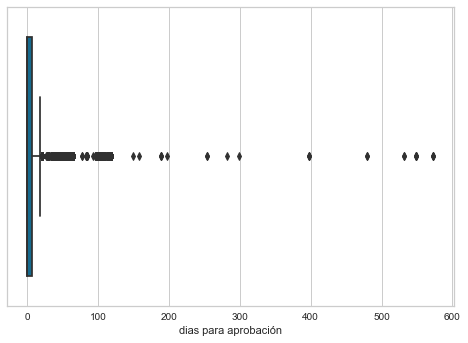

In [172]:
sns.boxplot(x=df['dias para aprobación']);

In [173]:
"""Cantidad de datos donde los dias de aprobación estan por arriba del tercer quantil"""
(df['dias para aprobación']>df['dias para aprobación'].quantile(0.75)).sum()


5274

In [174]:
df.loc[(df['dias para aprobación']>df['dias para aprobación'].quantile(0.75)),['USUARIO','USUARIO APROBADOR',
                                                                              'CATEGORÍA']].value_counts().head(8)

USUARIO                  USUARIO APROBADOR     CATEGORÍA                                  
Usuario solicitante 122  Usuario Aprobador 60  Vigilancia y seguridad industrial              5000
Usuario solicitante 50   Usuario Aprobador 25  Dotación y elementos de protección personal     130
Usuario solicitante 67   Usuario Aprobador 28  Alimentos y Bebidas                              16
Usuario solicitante 21   Usuario Aprobador 38  Aseo, Cafetería y Oficina                        13
Usuario solicitante 116  Usuario Aprobador 58  Moda y accesorios                                10
Usuario solicitante 50   Usuario Aprobador 19  Dotación y elementos de protección personal       8
Usuario solicitante 116  Usuario Aprobador 58  Alimentos y Bebidas                               7
                                               Vehículos y repuestos                             7
dtype: int64

In [175]:
df.loc[(df['USUARIO APROBADOR']=='Usuario Aprobador 60') & (df['USUARIO']=='Usuario solicitante 122'),['CATEGORÍA','ESTADO']].value_counts()

CATEGORÍA                          ESTADO  
Vigilancia y seguridad industrial  Recibido    5439
dtype: int64

In [178]:
df.loc[(df['USUARIO APROBADOR']=='Usuario Aprobador 60') & (df['USUARIO']=='Usuario solicitante 122'),'dias para aprobación'].max()


118.0

In [189]:
((df['USUARIO APROBADOR']=='Usuario Aprobador 60') & 
            (df['CATEGORÍA']=='Vigilancia y seguridad industrial') & (df['dias para aprobación']<
                                                                     df['dias para aprobación'].quantile(0.75)))


0        False
1        False
2        False
3        False
4        False
         ...  
23078    False
23079    False
23080    False
23081    False
23082    False
Length: 22392, dtype: bool

In [161]:
df['dias para aprobación']=np.where((df['USUARIO APROBADOR']=='Usuario Aprobador 60') & (df['CATEGORÍA']=='Vigilancia y seguridad industrial'),
                                    mean.values[0],df['dias para aprobación'])

In [162]:
df['dias para aprobación'].describe()

count    21259.000000
mean         1.572322
std         14.242060
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        573.000000
Name: dias para aprobación, dtype: float64

In [163]:
"""Cantidad de datos donde los dias de aprobación estan por arriba del tercer quantil"""
(df['dias para aprobación']>df['dias para aprobación'].quantile(0.75)).sum()


1684

In [164]:
df.groupby('CATEGORÍA')['dias para aprobación'].agg(['max','mean','median']).sort_values(by='mean',ascending=False).head(10)

,max,mean,median
CATEGORÍA,,,
Vigilancia y seguridad,573.0,39.241379,1.0
Moda y accesorios,532.0,22.695652,0.0
Vehículos y repuestos,549.0,6.428571,0.0
Medicina y Salud,55.0,5.600000,0.0
Dotación y elementos de protección personal,30.0,3.312707,1.0
Gestión ambiental,55.0,2.829268,0.0
Cuidado personal y Belleza,6.0,2.250000,1.0
Textiles,10.0,2.021429,2.0
Vigilancia y seguridad industrial,5.0,1.905726,2.0


# MODELO

In [7]:
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import random

### Variables usadas para entrenar el modelo inicial:
- Dia fecha aprobacion = Dia de la semana que se aprobo la orden
- Dia fecha orden = Dia de la semana que se hizo la orden
- Mes fecha orden = Mes del año que se realizo la orden
- semana del año orden = Semana del año que se hizo la orden
- Usuario aprobador = Usuario que aprueba la orden  
### Variable objetivo
- dias para aprobación = Fecha aprobacion - fecha orden 

In [66]:
variables=df[['dia fecha aprobacion', 'dia fecha orden',
       'mes fecha orden', 'semana del año orden','dias para aprobación']]

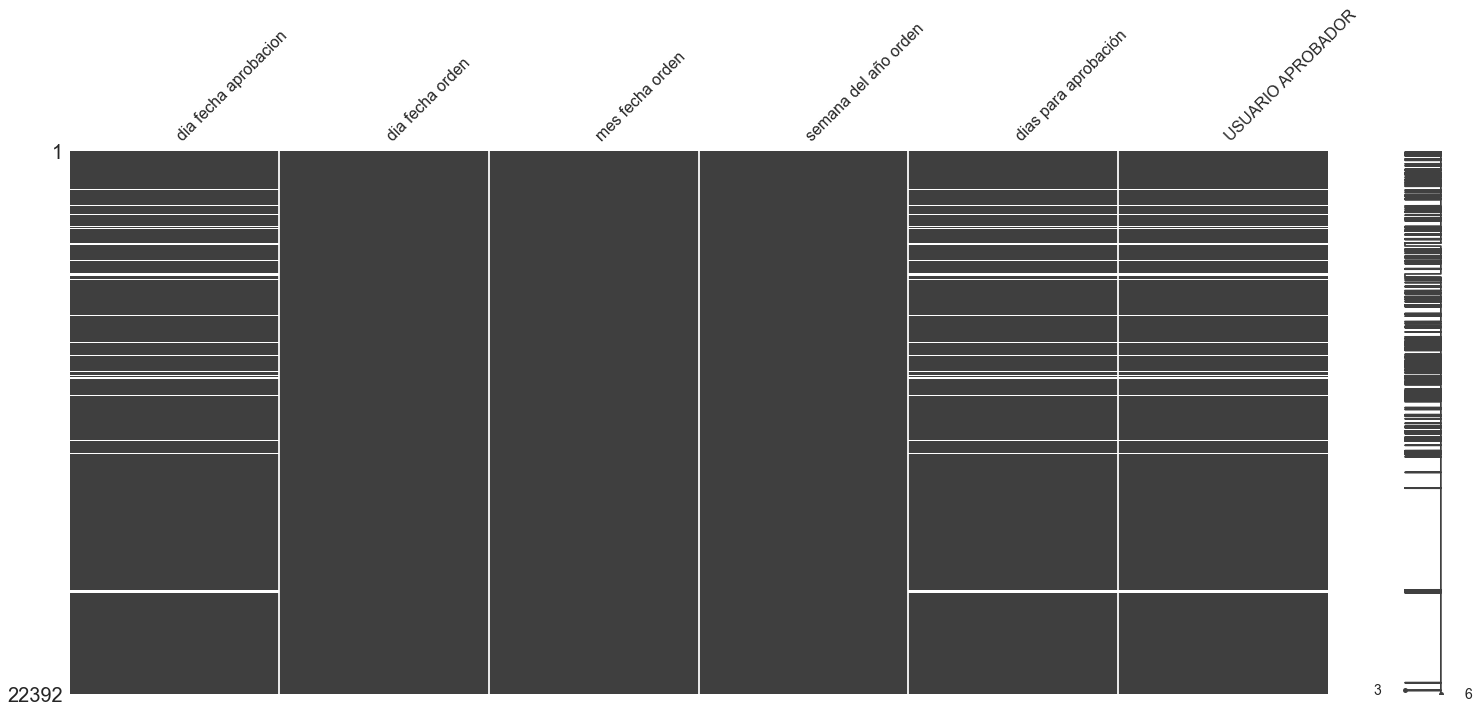

In [53]:
msn.matrix(variables);

In [67]:
variables.dropna(inplace=True)

In [9]:
#Manipulación de datos faltantes
# variables['dias para aprobación']=np.where(variables['dias para aprobación'].isnull()==True,variables['dias para aprobación'].mode(),
#                                           variables['dias para aprobación'])

"""Esto es solo una aproximación, creo que se puede mejorar bastante"""

'Esto es solo una aproximación, creo que se puede mejorar bastante'

In [68]:
#Acomodando los datos para entrarlos al modelo
variables['semana del año orden']=variables['semana del año orden'].astype('float64')
variables['dias para aprobación']=variables['dias para aprobación'].astype('int64')

In [70]:
#Datos de entrenamiento y prueba
random.seed(21)
train,test=train_test_split(variables,train_size=0.7)
print(train.shape)
print(test.shape)

(14881, 5)
(6378, 5)


In [71]:
setup(train,target='dias para aprobación',
            train_size=0.7,
            preprocess=True,
            remove_multicollinearity=True,
             multicollinearity_threshold=0.8,
            numeric_features=['dia fecha aprobacion','dia fecha orden',
                           'mes fecha orden','semana del año orden'],
      remove_outliers=True
      
            );

,Description,Value
0,session_id,2852
1,Target,dias para aprobación
2,Original Data,"(14881, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(9897, 3)"


In [72]:
compare_models(fold=10,sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.0982,262.8423,15.4482,0.6953,0.6478,1.1592,0.0520
rf,Random Forest Regressor,3.1199,263.7962,15.5271,0.6931,0.6534,1.1663,0.0680
lightgbm,Light Gradient Boosting Machine,3.8795,269.7929,15.6930,0.6869,0.7706,1.5067,0.0520
dt,Decision Tree Regressor,3.1420,269.3978,15.8492,0.6767,0.6535,1.1882,0.0050
knn,K Neighbors Regressor,3.1341,303.6115,16.6482,0.6461,0.6850,1.2477,0.0070
gbr,Gradient Boosting Regressor,5.1142,302.5385,16.7731,0.6448,0.9498,1.8056,0.0320
lr,Linear Regression,16.5569,709.2553,26.4250,0.1211,2.0188,4.1960,0.0040
ridge,Ridge Regression,16.5569,709.2553,26.4250,0.1211,2.0188,4.1958,0.0040
lar,Least Angle Regression,16.5569,709.2554,26.4250,0.1211,2.0187,4.1960,0.0050
br,Bayesian Ridge,16.5586,709.2574,26.4250,0.1211,2.0191,4.1884,0.0040


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=2852, verbose=0, warm_start=False)

In [73]:
#Elección de modelo
final_model=create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.1149,170.2012,13.0461,0.7194,0.7348,1.4078
1,2.7005,141.0855,11.8779,0.8019,0.6466,0.8543
2,3.1878,333.9244,18.2736,0.6038,0.6067,0.7606
3,2.7294,115.5170,10.7479,0.8407,0.6677,1.0402
4,3.4784,378.5939,19.4575,0.5983,0.6972,1.4949
5,3.2176,378.1350,19.4457,0.5864,0.6231,0.7851
6,4.1134,583.9911,24.1659,0.5105,0.6674,1.1564
7,2.4712,82.4815,9.0819,0.8594,0.5914,1.1957
8,2.6782,92.7558,9.6310,0.8607,0.5635,0.5956
9,3.2904,351.7374,18.7547,0.5717,0.6792,2.3013


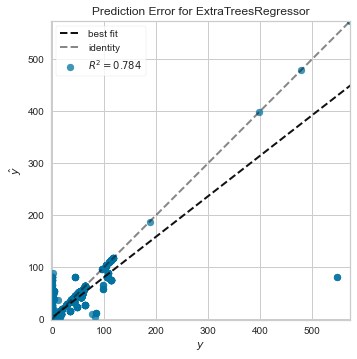

In [74]:
plot_model(final_model,plot='error')

In [77]:
predicciones=predict_model(final_model,data=test,round=2)
predicciones[['dias para aprobación','Label']].head(20)

,dias para aprobación,Label
21672,0,0.000000
13845,3,3.000000
19950,0,0.000000
2432,0,0.000000
18848,0,0.000000
3680,0,0.000000
20175,0,0.000000
14023,16,16.000000
8828,0,1.290000
4254,4,4.000000


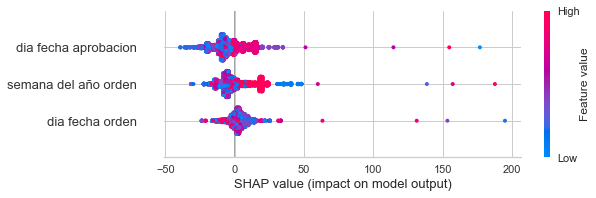

In [76]:
interpret_model(final_model)